Sta 663 - Statistical Computing and Computation - Midterm 1
-----------
Due Monday, March 20 by noon.

## Setup

In [1]:
# Load necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
# Load data
d1 = pd.read_csv("data/d1.csv")
d2 = pd.read_csv("data/d2.csv")
d3 = pd.read_csv("data/d3.csv")

<Axes: xlabel='x', ylabel='y'>

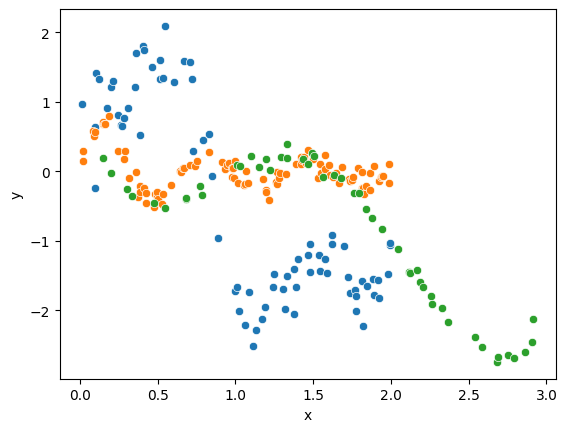

In [3]:

sns.scatterplot(
  data = d1,
  x = "x", 
  y = "y"
    
)
sns.scatterplot(
  data = d2,
  x = "x", 
  y = "y"
    
)
sns.scatterplot(
  data = d3,
  x = "x", 
  y = "y"
   
)




*Use the cell below to include any helper functions used by one or more of your functions in Tasks 1-3.*

*Remember that avoiding redundancy is an important aspect of writing maintainable code - we would suggest functions for
calculating distance and covariance matrices will likely come up in multiple tasks and would be good candidates for inclusion below.*

*Delete these instructions before submission*

In [4]:
#Helper function 
def exponentiated_quadratic(xi, xj,l):
    kernel = -(xi - xj) ** 2/(2*l)
    return  np.exp(kernel)

In [5]:
#Help function
def negativeloglikelihood(params):
    n = len(x)
    l = params[1]
    sigma_s2 = params[0]
    klist = []
    for i in range(n):
        klist.append(exponentiated_quadratic(x[i],x,l))

    kmatrix = np.array(klist)
    kmatrix = kmatrix.reshape((n,n))
    covmatrix = 0.1 * np.identity(n) + sigma_s2 * kmatrix
    lml = -0.5 * (n * np.log(2 * np.pi) + np.log(np.linalg.det(covmatrix)) + y.T.dot(np.linalg.inv(covmatrix)).dot(y))
    return -lml


## Task 1 - Model fitting

The two helper functions above (exponential_quadratic() and negativeloglikelihood()) are used to construct the covariance matrix given in the readme and loglikelihood. To estimate the parameters $\sigma_s^2$ and $l$ is to maximize the loglikelihood or minimize the negative loglikelihood based on the data. Therefore, I use "nelder-mead" method to minimize the negative loglikelihood and the pick up the one with maximum likelihood as the best for ouput.

In [6]:
def fit(d, n_init, lb, ub, seed):
    x = np.array(d['x'])
    y = np.array(d['y'])
    rng = np.random.default_rng(seed)
    mle = []
    nits = []
    nloglikeli = []
    for i in range(n_init):
        params_guess = rng.uniform(lb,ub)
        ret = optimize.minimize(negativeloglikelihood, params_guess, method='nelder-mead',bounds = [(lb[0], ub[0]), (lb[1], ub[1])])
        if (ret.success):
            mle.append(ret.x)
            nits.append(ret.nit)
            nloglikeli.append(negativeloglikelihood(ret.x))

    if len(mle) == 0:
        raise RuntimeError("All failed!!!!")

    index = np.argmin(np.array(nloglikeli))
    output = mle[index].tolist()

    return [0.1] + output

In [7]:
seed1 = 663
seed2 = 718
seed3 = 561
lb = [1e-6,1e-6]
ub = [0.1,0.1]
x = np.array(d1['x'])
y = np.array(d1['y'])
theta1 = fit(d1, 20, lb, ub, seed1); print(theta1) # Add arguments as needed
lb = [1e-6,1e-6]
ub = [5,5]
x = np.array(d2['x'])
y = np.array(d2['y'])
theta2 = fit(d2, 20, lb, ub, seed2); print(theta2) # Add arguments as needed
lb = [1e-6,1e-6]
ub = [2,2]
x = np.array(d3['x'])
y = np.array(d3['y'])
theta3 = fit(d3, 20, lb, ub, seed3); print(theta3) # Add arguments as needed

[0.1, 0.1, 0.055656601001457945]
[0.1, 0.062078303899533144, 0.022299603318016024]
[0.1, 2.0, 0.5952129132344219]


## Task 2 - Prediction

To randomly generate $y_p$, we need to get its conditional predictive distribution given $y$, $x$, $x_p$. I use two hleper functions getmustar() and getsigmastar() to compute $\mu^\star$ and $\Sigma^\star$, which are the parameters for the distribution of $y_p$. Then multivariate_normal() from numpy.random is used to generate $y_p$ and stored in a pandas dataframe.

In [8]:
def getmustar(x_p,x,y,theta):

    kernel_xp_x_list = []
    for i in range(len(x_p)):
        kernel_xp_x_list.append(exponentiated_quadratic(x_p[i],x,theta[2]))
    kernel_xp_x = np.array(kernel_xp_x_list)
    kernel_xp_x = kernel_xp_x.reshape((len(x_p),len(x_p)))
    sigma_xp_x = theta[0] * np.identity(len(x)) + theta[1] * kernel_xp_x

    

    kernel_x_list = []
    for i in range(len(x)):
        kernel_x_list.append(exponentiated_quadratic(x[i],x,theta[2]))
    kernel_x = np.array(kernel_x_list)
    kernel_x = kernel_x.reshape((len(x),len(x)))
    sigma_x = theta[0] * np.identity(len(x)) + theta[1] * kernel_x

    mustar = (sigma_xp_x.dot(np.linalg.inv(sigma_x))).dot(y)

    return mustar



In [9]:
def getsigmastar(x_p,x,y,theta):
    kernel_xp_x_list = []
    for i in range(len(x_p)):
        kernel_xp_x_list.append(exponentiated_quadratic(x_p[i],x,theta[2]))
    kernel_xp_x = np.array(kernel_xp_x_list)
    kernel_xp_x = kernel_xp_x.reshape((len(x_p),len(x_p)))
    sigma_xp_x = theta[0] * np.identity(len(x)) + theta[1] * kernel_xp_x

    

    kernel_xp_list = []
    for i in range(len(x_p)):
        kernel_xp_list.append(exponentiated_quadratic(x_p[i],x_p,theta[2]))
    kernel_xp = np.array(kernel_xp_list)
    kernel_xp = kernel_xp.reshape((len(x_p),len(x_p)))
    sigma_xp = theta[0] * np.identity(len(x_p)) + theta[1] * kernel_xp

    kernel_x_list = []
    for i in range(len(x)):
        kernel_x_list.append(exponentiated_quadratic(x[i],x,theta[2]))
    kernel_x = np.array(kernel_x_list)
    kernel_x = kernel_x.reshape((len(x),len(x)))
    sigma_x = theta[0] * np.identity(len(x)) + theta[1] * kernel_x

    sigmastar = sigma_xp - (sigma_xp_x.dot(np.linalg.inv(sigma_x))).dot(sigma_xp_x.T)

    return sigmastar

In [10]:
def predict(d, theta, x_p, n_draws, seed):
    rng = np.random.default_rng(seed)
    mustar = getmustar(x_p,x,y,theta)
    sigmastar = getsigmastar(x_p,x,y,theta)
    rand = rng.multivariate_normal(mustar, sigmastar, size = n_draws)
    df = pd.DataFrame()
    df['x_p'] = x_p
    for i in range(n_draws):
        df['y_' + str(i)] = rand[i]
        
    
    return df

In [11]:
seed1 = 663
seed2 = 718
seed3 = 561
n_draws = 100
x = np.array(d1['x'])
y = np.array(d1['y'])
x_p = np.linspace(min(x),max(x),len(y))
pred1 = predict(d1,theta1, x_p, n_draws, seed1) # Add arguments as needed
x = np.array(d2['x'])
y = np.array(d2['y'])
x_p = np.linspace(min(x),max(x),len(y))
pred2 = predict(d2,theta2, x_p, n_draws, seed2) # Add arguments as needed
x = np.array(d3['x'])
y = np.array(d3['y'])
x_p = np.linspace(min(x),max(x),len(y))
pred3 = predict(d3,theta3, x_p, n_draws, seed3) # Add arguments as needed

/tmp/ipykernel_1864588/1964199161.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['y_' + str(i)] = rand[i]
/tmp/ipykernel_1864588/1964199161.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['y_' + str(i)] = rand[i]
/tmp/ipykernel_1864588/1964199161.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fra

In [12]:
pred1

,x_p,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,...,y_90,y_91,y_92,y_93,y_94,y_95,y_96,y_97,y_98,y_99
0,0.015744,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,...,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680
1,0.042488,0.580495,0.524552,0.580002,0.524683,0.546387,0.483407,0.559905,0.594528,0.645697,...,0.540876,0.685954,0.563909,0.559032,0.575801,0.604047,0.636691,0.553284,0.576988,0.600060
2,0.069231,-0.272578,-0.299516,-0.271244,-0.305708,-0.287135,-0.328878,-0.279409,-0.267240,-0.233688,...,-0.290968,-0.205028,-0.282890,-0.281527,-0.281215,-0.253557,-0.237895,-0.284347,-0.271871,-0.255205
3,0.095974,1.397089,1.390575,1.397900,1.386707,1.394268,1.380003,1.396524,1.397889,1.409094,...,1.392960,1.419369,1.393599,1.395460,1.392846,1.404493,1.408216,1.394657,1.398001,1.404211
4,0.122718,1.323127,1.323122,1.323128,1.323116,1.323126,1.323109,1.323128,1.323126,1.323139,...,1.323125,1.323151,1.323122,1.323126,1.323120,1.323136,1.323139,1.323126,1.323128,1.323136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1.887775,-1.662203,-1.610963,-1.615229,-1.606691,-1.623062,-1.602419,-1.617717,-1.617796,-1.623457,...,-1.628165,-1.595703,-1.629902,-1.618169,-1.624335,-1.618473,-1.615786,-1.654107,-1.619985,-1.632793
71,1.914518,-1.857935,-1.843153,-1.845891,-1.842646,-1.846124,-1.841956,-1.846059,-1.845123,-1.847274,...,-1.846539,-1.840503,-1.849711,-1.845921,-1.847759,-1.846940,-1.845175,-1.855435,-1.846302,-1.848417
72,1.941262,-1.681324,-1.579997,-1.623815,-1.587906,-1.590923,-1.585916,-1.617059,-1.588447,-1.610697,...,-1.576667,-1.587882,-1.640711,-1.611135,-1.622051,-1.630652,-1.599650,-1.657142,-1.609385,-1.598940
73,1.968005,-1.195136,-1.132918,-1.165679,-1.140087,-1.137370,-1.138623,-1.159906,-1.135852,-1.151348,...,-1.124657,-1.143356,-1.173424,-1.154944,-1.160577,-1.169327,-1.145285,-1.177865,-1.152570,-1.140506


## Task 3 - Plotting

Now in each pred dataframe, we have one column for $x_p$ and n_draws  columns for $y_p$. Treating the n_draws columns of $y_p$ as a dataframe, I calculate the mean and standard deviation along the row. Then for each element in $x_p$, we would have a corresponding mean prediction and its upper bound and lower bound for the 95% confidence interval. The plot is made by filling in the gap between each pair of upper bound and lower bound on the basis of the scatterplot of $x_p$ and mean $y_p$.

In [13]:
def plot_gp(pred,namedcolor):
    y_mean = pred.loc[:, pred.columns != 'x_p'].mean(axis=1)
    y_std = pred.loc[:, pred.columns != 'x_p'].std(axis=1)
    ci_low = y_mean - 1.96 * y_std
    ci_up = y_mean + 1.96 * y_std
    plt.figure(figsize=(6,5))

    plt.plot(pred['x_p'],y_mean,'-',color = namedcolor)
    plt.fill_between(pred['x_p'], ci_low, ci_up, color=namedcolor, alpha=0.3)
    plt.ylim(bottom = -3,top=3)

    plt.show()
    pass

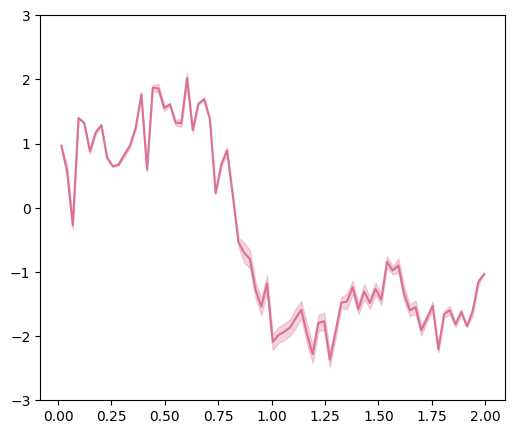

In [14]:
plot_gp(pred1, 'palevioletred')

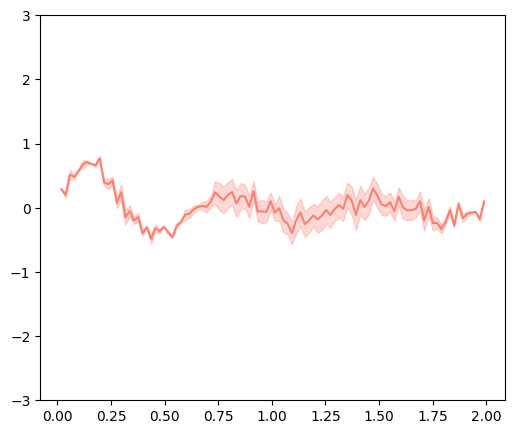

In [15]:
plot_gp(pred2, 'salmon')

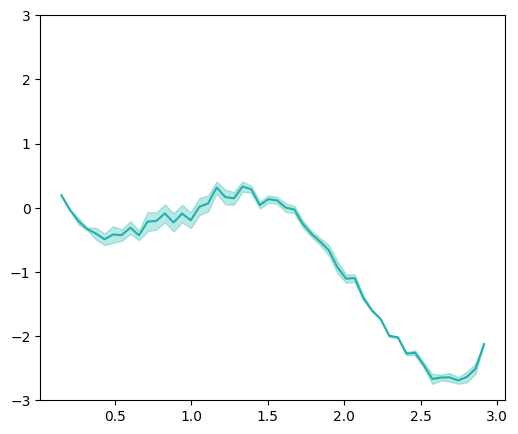

In [16]:
plot_gp(pred3, 'lightseagreen')

<Axes: xlabel='x_p'>

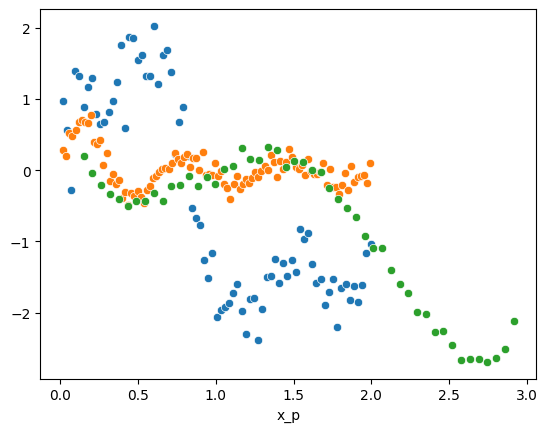

In [70]:
sns.scatterplot(
  data = pred1,
  x = "x_p", 
  y = pred1.loc[:, pred1.columns != 'x_p'].mean(axis=1)
    
)
sns.scatterplot(
  data = pred2,
  x = "x_p", 
  y = pred2.loc[:, pred2.columns != 'x_p'].mean(axis=1)
    
)
sns.scatterplot(
  data = pred3,
  x = "x_p", 
  y = pred3.loc[:, pred3.columns != 'x_p'].mean(axis=1)
   
)



<Axes: xlabel='x', ylabel='y'>

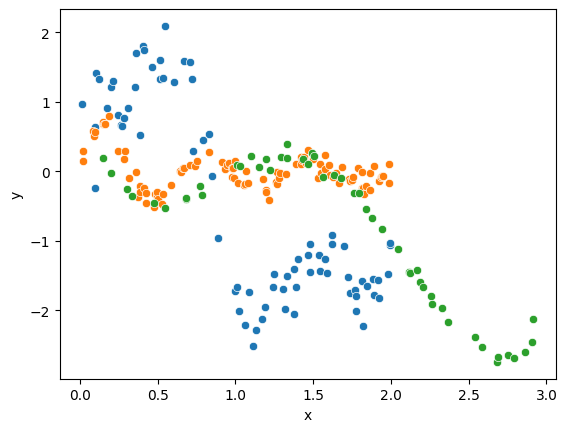

In [71]:

sns.scatterplot(
  data = d1,
  x = "x", 
  y = "y"
    
)
sns.scatterplot(
  data = d2,
  x = "x", 
  y = "y"
    
)
sns.scatterplot(
  data = d3,
  x = "x", 
  y = "y"
   
)


